In [1]:
# import packages
import numpy as np
import seaborn as sns
from scipy.stats import wishart, dirichlet, expon, norm
import scipy.special as sc
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D 
import dirichlet
import json # to save result

In [2]:
def para_x(u, s2, tao):
    lambdax = np.dot(s2.T, u).reshape(d,d)
    sx = np.linalg.inv(lambdax) # variance of x
    taox = np.dot(tao.T, u) # sum_j(u_j * tao_j)
    mux = np.dot(sx, taox) # mu(x)
    return sx, mux 
def document_generator(a, rho, T, s2, tao, N):
    '''
    Given the corpus, generate more documents.
    All corpus-level parameters are given.
    N: the number of documents.
    
    output: 
    X: N*d, X[i] = document[i]
    Y: Y[i] = label[i]
    G: membership
    U: transformed membership
    '''

    nlabel = len(T) # number of y
    d = len(tao[0]) # dim(x)
    
    Y = np.random.choice(list(range(nlabel)),N) # labels
    G = np.random.dirichlet(a*rho,N)
    U = np.array([np.dot(T[Y[i]], G[i]) for i in range(N)])

    X = []
    
    for i in range(N):
        sx, mux = para_x(U[i], s2, tao)
        X.append(np.random.multivariate_normal(mux, sx))
    X = np.array(X)

    return X, Y, G, U

def check_p(a, rho, mu, s_inv):
    '''
    Input: the parameters used in the data
    1. Check whether a and rho will generate extremely small g
    2. See distributions of different topics
    '''
    ntopic = len(mu)
    g = np.random.dirichlet(a*rho, 100)
#     print("The minimum component of g is",g.min())
    
    print("Distribution of pure types")
    s = [np.linalg.inv(i) for i in s_inv]
    pX = np.concatenate(tuple([np.random.multivariate_normal(mu[i], s[i], 100) for i in range(ntopic)]))
    pY = [[i]*100 for i in range(ntopic)]
    fig_pure_type = plt.figure()
    ax = Axes3D(fig_pure_type)
    ax.scatter(pX[:, 0], pX[:, 1], pX[:, 2], c = pY)
    plt.show()

the value of a: 20.204406609354525


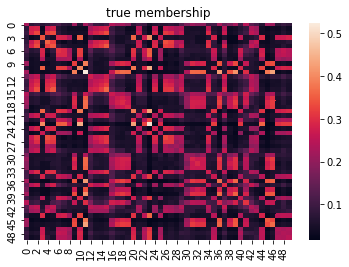

Distribution of pure types


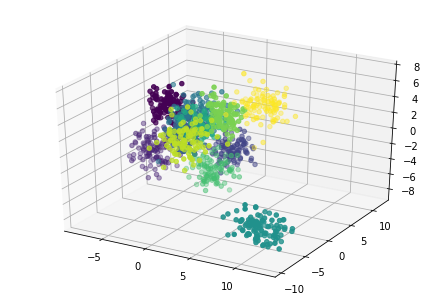

In [5]:
# set parameters
d = 30
k0, k1 = 2,5
nlabel = 3
alpha = np.ones(7)
b = 0.1
para_topic = [np.zeros(d),0.1,np.eye(d)/3/d, 3*d]
N, sigmaa, sigmarho, sigmag, nconverge, nskip, nsave =  50, 1,0.1,0.1,10, 10,500
# define T
dg = k0 + k1 
ntopic = nlabel*k0+k1
T = []
for i in range(nlabel):
    tem = np.block([
        [np.zeros((k0*i,k0+k1))],
        [np.eye(k0), np.zeros((k0, k1))],
        [np.zeros((k0*(nlabel-i-1),k0+k1))],
        [np.zeros((k1,k0)), np.eye(k1)]
    ])
    T.append(tem)
# draw corpus-level parameters
rho = np.random.dirichlet(alpha, 1)[0]
a = np.random.exponential(1/b,1)[0]

mu0, lambda0, W, nu = para_topic
d = len(mu0)
s_inv = wishart.rvs(df = nu, scale = W, size=ntopic) # sigma inverse
mu = np.array([np.random.multivariate_normal(mu0, 1/lambda0*np.linalg.inv(i)) for i in s_inv])    
s2 = np.array([i.flatten() for i in s_inv]) # flatten s_inv, s2[i].reshape(d,d) = s_inv[i]
tao = np.array([np.dot(s_inv[i], mu[i]) for i in range(ntopic)]) # sigma^-1 mu    
# generate data
X, Y, G, U = document_generator(a, rho, T, s2, tao, N)
print("the value of a:", a)
trueU = sns.heatmap(np.dot(U,U.T))
plt.title("true membership")
plt.show()
check_p(a, rho, mu, s_inv)

In [6]:
def simplex_proposal(g, sigma):
    '''
    g is in simplex
    z[i] = log g[i]/g[-1]
    draw newz~N(z, sigma*I)
    newz -> newg
    '''
    z = np.log(g[:-1]/g[-1])
    newz = np.random.multivariate_normal(z, sigma*np.eye(len(z)))
    newg = np.exp(np.append(newz,0))
    newg /= newg.sum()
    return newg

def px(x, u, s2, tao):
    # return 0.5*log|lambda_x|-0.5(x-mux)^T*lambda_x*(x-mux)
    
    lambdax = np.dot(s2.T, u).reshape(d,d)
    sx = np.linalg.inv(lambdax) # variance of x
    taox = np.dot(tao.T, u) # sum_j(u_j * tao_j)
    mux = np.dot(sx, taox) # mu(x)
    
    return 0.5*np.log(np.linalg.det(lambdax))-0.5*np.dot(np.dot((x-mux).T, lambdax), x-mux)

In [7]:
def gibbs(X, Y, alpha, b, T, s2, tao, sigmaa, sigmarho, sigmag, nconverge, nskip, nsave,rho_1,rho_2,a_1, a_2):
#     gibbs(X, Y, alpha, b, T, s2, tao, sigmaa, sigmarho, sigmag, 10, nskip, nsave,rho_1,rho_2,a_1, a_2)
    '''
    rho: mle, mean, on ac rate
    a: mle, sampling, has ac rate
    '''
        
    nlabel = len(T)
    dg = len(alpha)
    ntopic = len(T[0])
    d = len(X[0])
    N = len(Y)  
    
    infinity = 10**(-5) # To avoid overflow, if we get g or rho smaller than this
    
    
    # initialization
    rho1 = np.random.dirichlet(np.ones(dg), 1)[0]
    G1 = np.random.dirichlet(np.ones(dg), N)
    a1 = np.random.exponential(1/b,1)[0]    
#     a1 = a
    probx = [px(X[i], np.dot(T[Y[i]], G1[i]), s2, tao) for i in range(N)]
    
    asave, Gs, rhos, ara, arG, arrho = [], [], [], [], [], [] # estimates and accept rates
    ca = cg = crho = 0 # count of accepted proposals
    
    for step in range(nconverge//nskip):
        ca = cg = crho = 0
        
        for t in range(nskip):
        # update G
            for i in range(N):
                oldg = G1[i]
                newg = simplex_proposal(oldg, sigmag)
                if newg.min()<infinity: newg = (newg + infinity*np.ones(dg))/(1+infinity)
                newpx = px(X[i], np.dot(T[Y[i]], newg), s2, tao)
#                 oldp = ((a1*rho1-1)*np.log(oldg)).sum() + probx[i]
#                 newp = ((a1*rho1-1)*np.log(newg)).sum() + newpx
                oldp = probx[i]
                newp = newpx                
                ag = min(1, np.exp(min(1,newp-oldp))) # avoid overflow when newp>>oldp
                if np.random.uniform() < ag:
                    G1[i] = newg # update G
                    probx[i] = newpx # update px
                    cg += 1
        
            es = dirichlet.mle(G1)
            logG = np.log(G1).sum(axis = 0)
            if rho_1 == "mean":
                rho1 = rho1 = G1.sum(axis=0)/N  
            elif rho_1 == "mle":
                rho1 = es/es.sum()
            if a_1 == "sampling":
                newa = np.random.normal(a1, sigmaa)
                while newa<0: newa = np.random.normal(a1, sigmaa) # truncated Gaussian N(a, sigmaa)
                newp = -b*newa + N*sc.loggamma(newa) - N*(sc.loggamma(newa*rho1)).sum() + ((newa*rho1-1)*logG).sum()
                oldp = -b*a1 + N*sc.loggamma(a1) - N*(sc.loggamma(a1*rho1)).sum() + ((a1*rho1-1)*logG).sum()
                aa = min(1, np.exp(min(1,newp-oldp+np.log((1-norm.cdf(0,newa,sigmaa))/(1-norm.cdf(0,a1,sigmaa))))))
                if np.random.uniform() < aa:
                    a1 = newa
                    ca += 1   
            elif a_1 == "mle":
                a1 = es.sum() 

        Gs.append(G1.copy())
        arG.append(cg/nskip/N)  
        rhos.append(rho1.copy())
        arrho.append(crho/nskip)
        asave.append(a1)
        ara.append(ca/nskip)
    
    
    for step in range(nsave):
        ca = cg = crho = 0
        
        for t in range(nskip):
        # update G
            for i in range(N):
                oldg = G1[i]
                newg = simplex_proposal(oldg, sigmag)
                if newg.min()<infinity: newg = (newg + infinity*np.ones(dg))/(1+infinity)
                newpx = px(X[i], np.dot(T[Y[i]], newg), s2, tao)
#                 oldp = ((a1*rho1-1)*np.log(oldg)).sum() + probx[i]
#                 newp = ((a1*rho1-1)*np.log(newg)).sum() + newpx
                oldp = probx[i]
                newp = newpx 
                ag = min(1, np.exp(min(1,newp-oldp))) # avoid overflow when newp>>oldp
                if np.random.uniform() < ag:
                    G1[i] = newg # update G
                    probx[i] = newpx # update px
                    cg += 1
        
            es = dirichlet.mle(G1)
            logG = np.log(G1).sum(axis = 0)
            if rho_2 == "mean":
                rho1 = G1.sum(axis=0)/N  
            elif rho_2 == "mle":
                rho1 = es/es.sum()
            if a_2 == "sampling":
                newa = np.random.normal(a1, sigmaa)
                while newa<0: newa = np.random.normal(a1, sigmaa) # truncated Gaussian N(a, sigmaa)
                newp = -b*newa + N*sc.loggamma(newa) - N*(sc.loggamma(newa*rho1)).sum() + ((newa*rho1-1)*logG).sum()
                oldp = -b*a1 + N*sc.loggamma(a1) - N*(sc.loggamma(a1*rho1)).sum() + ((a1*rho1-1)*logG).sum()
                aa = min(1, np.exp(min(1,newp-oldp+np.log((1-norm.cdf(0,newa,sigmaa))/(1-norm.cdf(0,a1,sigmaa))))))
                if np.random.uniform() < aa:
                    a1 = newa
                    ca += 1   
            elif a_2 == "mle":
                a1 = es.sum() 

        Gs.append(G1.copy())
        arG.append(cg/nskip/N)  
        rhos.append(rho1.copy())
        arrho.append(crho/nskip)
        asave.append(a1)
        ara.append(ca/nskip)
    return np.array(asave), np.array(Gs), np.array(rhos), np.array(ara), np.array(arG), np.array(arrho)

def tuningp(sigmaa=0.1, sigmarho=0.1, sigmag=0.1, nconverge=10, nskip=10, nsave=10,a=0,rho_1="mean",rho_2="mean",a_1="sampling", a_2="sampling"):
    asave, Gs, rhos, ara, arG, arrho = gibbs(X, Y, alpha, b, T, s2, tao, sigmaa, sigmarho, sigmag, nconverge, nskip, nsave,rho_1,rho_2,a_1, a_2)
    print("accept rate of a, G for the last iteration:",arG[-1])
    G1 = Gs[-1]
    N = len(X)
    print("ave error G:", (abs(G-G1)).sum()/N)
    print("error rho:", abs(rhos[-1]-rho).sum())
    print("error a:", asave[-1]-a)
    # Summary G
    differenceG = abs(G-G1).sum(axis=1)
    error_summary_G = []
    print("\n")
    for tt in range(5,0,-1):
        tem = tt/10
        error_summary_G.append(sum([1 for i in range(N) if differenceG[i]<tem])/N)
        print("P(difference<"+str(tem)+")=", error_summary_G[-1])

    eU = sns.heatmap(np.dot(G1,G1.T))
    plt.title("estimated membership")
    plt.show()
    
    # error G
    errorG = abs(Gs - G).sum(axis=1).sum(axis=1)/N
    plt.scatter([i*nskip for i in range(len(errorG))], errorG, s=5)
    plt.title("estimation error of G")
    plt.xlabel("t")
    plt.ylabel("error")
    plt.show()
    # ar G
    plt.scatter([i*nskip for i in range(len(arG))], arG, s=5)
    plt.title("acc rate of G")
    plt.xlabel("t")
    plt.ylabel("error")
    plt.show()
    # error rho
    errorrho = abs(rhos - rho).sum(axis=1)
    plt.scatter([i*nskip for i in range(len(errorrho))], errorrho, s=5)
    plt.title("estimation error of rho")
    plt.xlabel("t")
    plt.ylabel("error")
    plt.show()
    # error a
    errora = asave - a
    plt.scatter([i*nskip for i in range(len(errora))], errora, s=5)
    plt.title("estimation error of a")
    plt.xlabel("t")
    plt.ylabel("error")
    plt.show()
    # ar a
    if a_2 == 'sampling':
        plt.scatter([i*nskip for i in range(len(ara))], ara, s=5)
        plt.title("acc rate of a")
        plt.xlabel("t")
        plt.ylabel("error")
        plt.show()

    return asave, Gs, rhos, ara, arG, arrho
# test
# asave, Gs, rhos, ara, arG, arrho = tuningp(sigmaa=0.1, sigmarho=0.1, sigmag=0.1, nconverge=100, nskip=10, nsave=10,a=0,rho_1="mean",rho_2="mean",a_1="mle", a_2="mle")

----------------------------------------------------------------------------------------------------
rho_1, rho_2, a_1, a_2 = mean, mean, mle, mle	
accept rate of a, G for the last iteration: 0.764
ave error G: 0.41242310218158607
error rho: 0.14008976415230762
error a: -15.8446754813618


P(difference<0.5)= 0.72
P(difference<0.4)= 0.58
P(difference<0.3)= 0.3
P(difference<0.2)= 0.06
P(difference<0.1)= 0.0


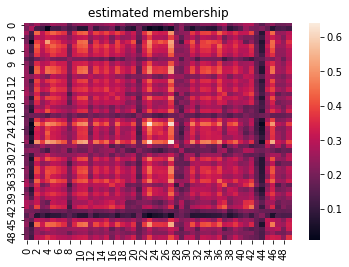

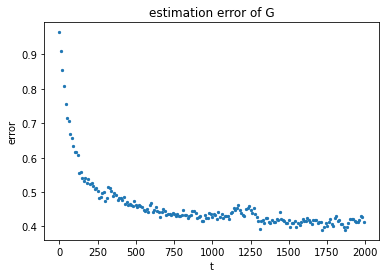

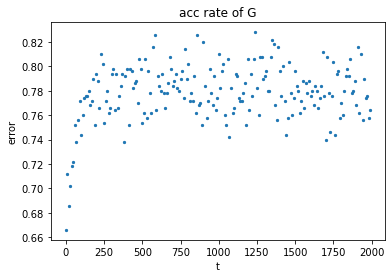

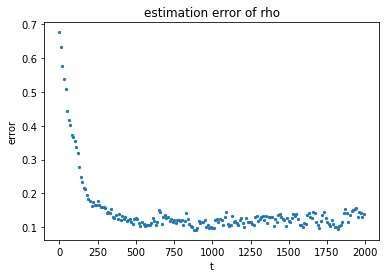

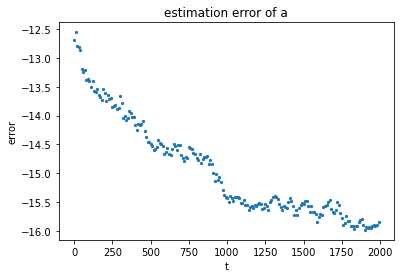

----------------------------------------------------------------------------------------------------
rho_1, rho_2, a_1, a_2 = mean, mean, mle, sampling	
accept rate of a, G for the last iteration: 0.77
ave error G: 0.4648588969339347
error rho: 0.15488771566123802
error a: -14.828105605331842


P(difference<0.5)= 0.72
P(difference<0.4)= 0.38
P(difference<0.3)= 0.06
P(difference<0.2)= 0.04
P(difference<0.1)= 0.0


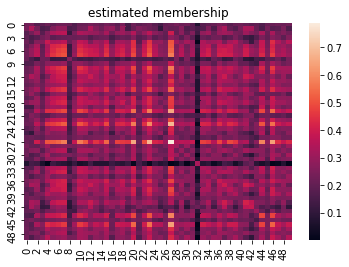

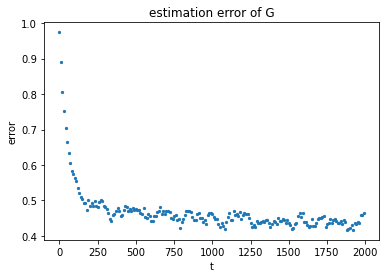

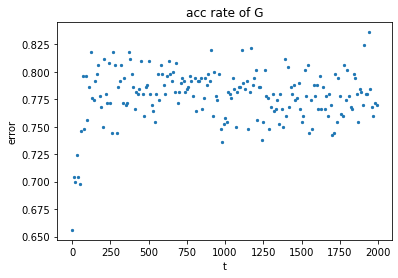

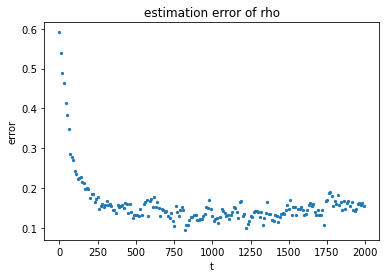

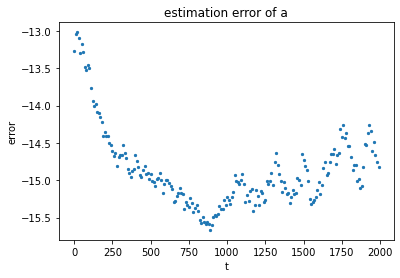

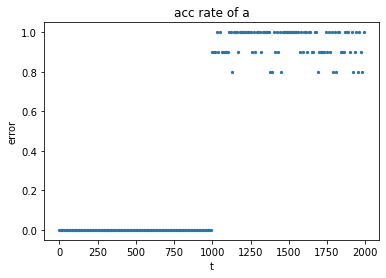

----------------------------------------------------------------------------------------------------
rho_1, rho_2, a_1, a_2 = mean, mean, sampling, mle	
accept rate of a, G for the last iteration: 0.7859999999999999
ave error G: 0.40641304172597204
error rho: 0.16564544296077893
error a: -15.916952221841736


P(difference<0.5)= 0.86
P(difference<0.4)= 0.46
P(difference<0.3)= 0.28
P(difference<0.2)= 0.02
P(difference<0.1)= 0.0


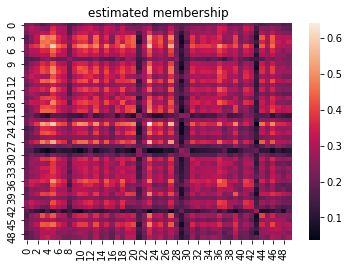

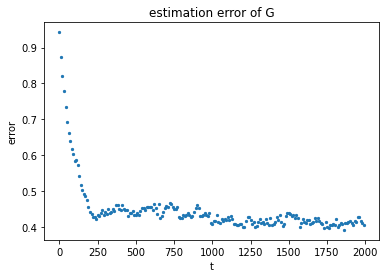

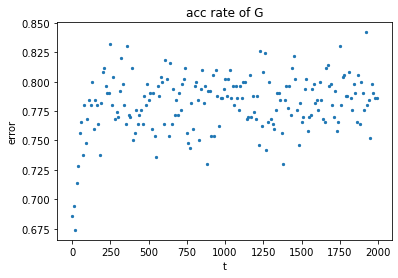

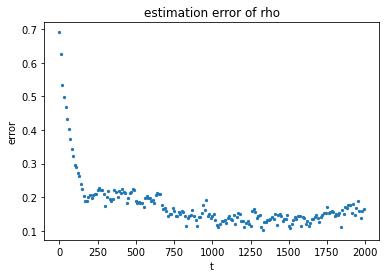

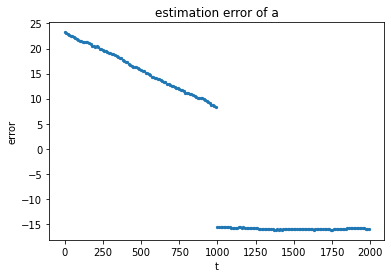

----------------------------------------------------------------------------------------------------
rho_1, rho_2, a_1, a_2 = mean, mean, sampling, sampling	
accept rate of a, G for the last iteration: 0.794
ave error G: 0.3975510817276323
error rho: 0.16630403257658288
error a: -15.060653027842543


P(difference<0.5)= 0.8
P(difference<0.4)= 0.58
P(difference<0.3)= 0.18
P(difference<0.2)= 0.04
P(difference<0.1)= 0.0


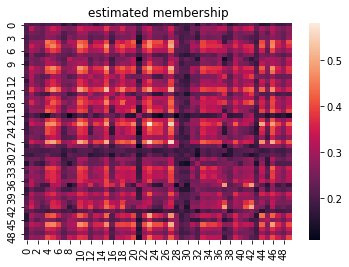

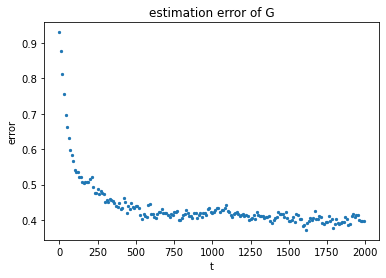

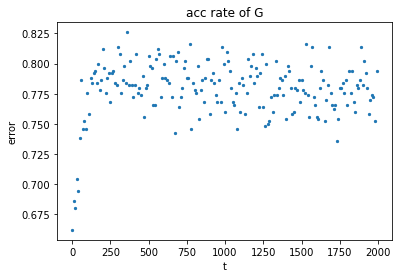

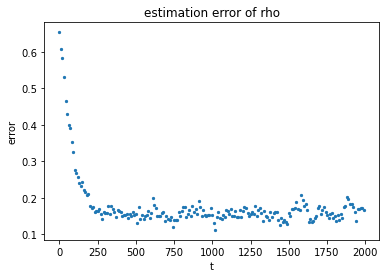

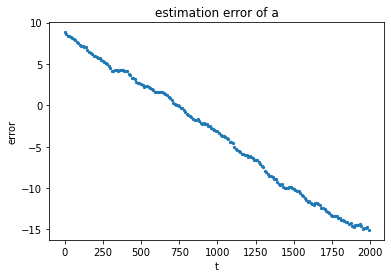

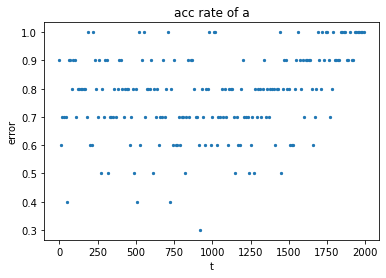

----------------------------------------------------------------------------------------------------
rho_1, rho_2, a_1, a_2 = mean, mle, mle, mle	
accept rate of a, G for the last iteration: 0.77
ave error G: 0.4422784624136025
error rho: 0.3035048936610311
error a: -16.62520898922278


P(difference<0.5)= 0.72
P(difference<0.4)= 0.54
P(difference<0.3)= 0.26
P(difference<0.2)= 0.08
P(difference<0.1)= 0.0


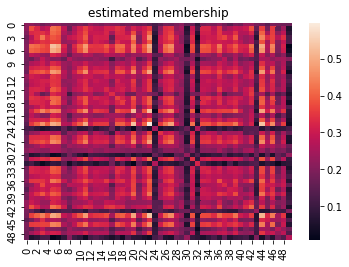

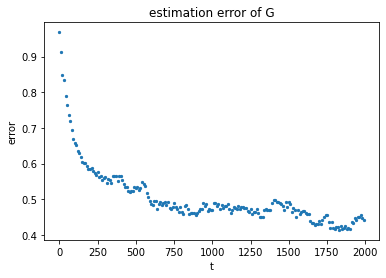

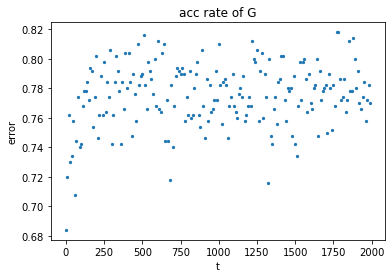

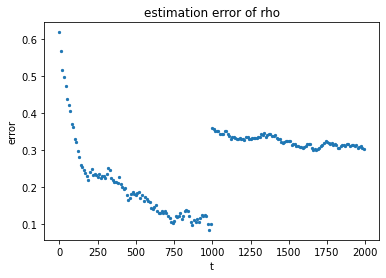

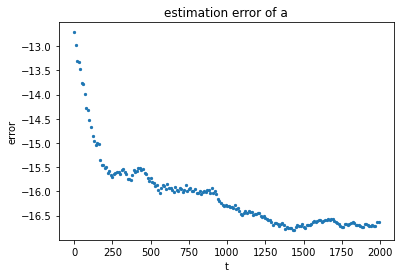

----------------------------------------------------------------------------------------------------
rho_1, rho_2, a_1, a_2 = mean, mle, mle, sampling	
accept rate of a, G for the last iteration: 0.748
ave error G: 0.3978372140410225
error rho: 0.17317843383534026
error a: -15.73462464637431


P(difference<0.5)= 0.82
P(difference<0.4)= 0.58
P(difference<0.3)= 0.3
P(difference<0.2)= 0.12
P(difference<0.1)= 0.0


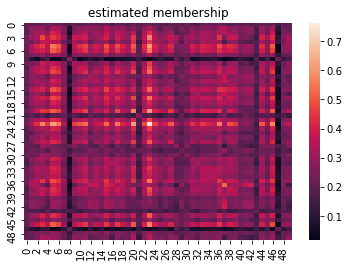

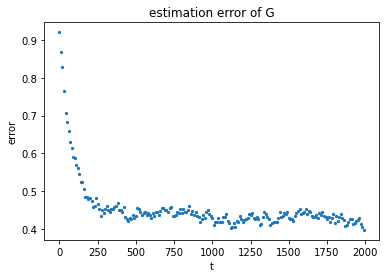

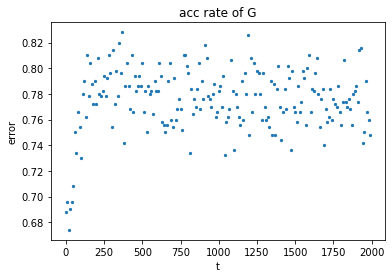

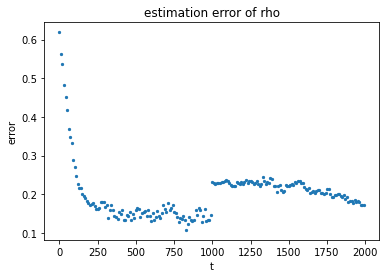

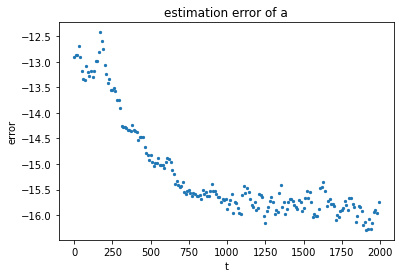

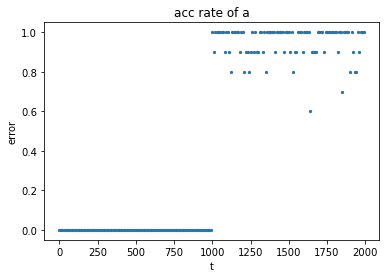

----------------------------------------------------------------------------------------------------
rho_1, rho_2, a_1, a_2 = mean, mle, sampling, mle	
accept rate of a, G for the last iteration: 0.78
ave error G: 0.4419869393322807
error rho: 0.24558722293355553
error a: -15.96215331317778


P(difference<0.5)= 0.64
P(difference<0.4)= 0.42
P(difference<0.3)= 0.28
P(difference<0.2)= 0.06
P(difference<0.1)= 0.0


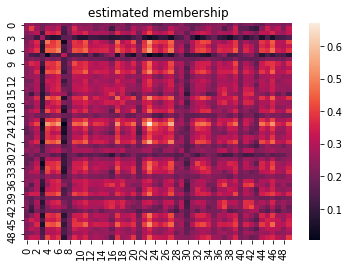

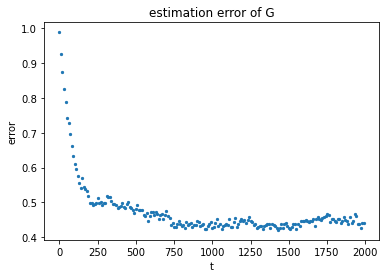

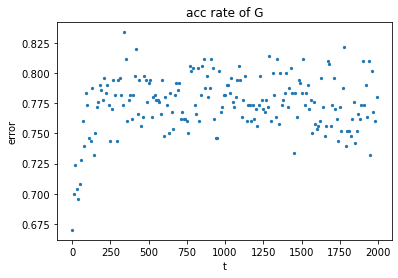

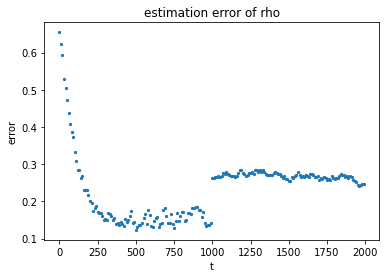

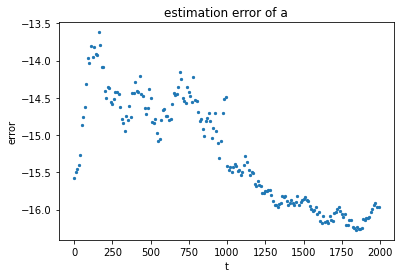

----------------------------------------------------------------------------------------------------
rho_1, rho_2, a_1, a_2 = mean, mle, sampling, sampling	
accept rate of a, G for the last iteration: 0.8140000000000001
ave error G: 0.4320557756004548
error rho: 0.21468433210394305
error a: -16.0254573373566


P(difference<0.5)= 0.76
P(difference<0.4)= 0.5
P(difference<0.3)= 0.18
P(difference<0.2)= 0.08
P(difference<0.1)= 0.0


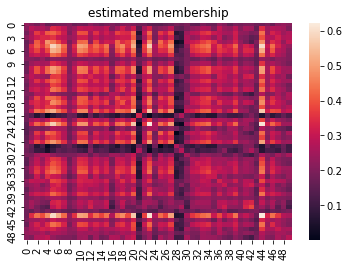

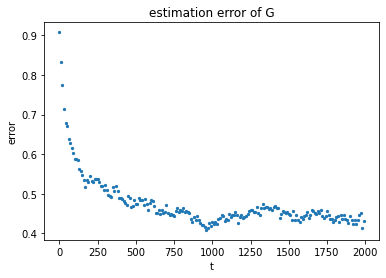

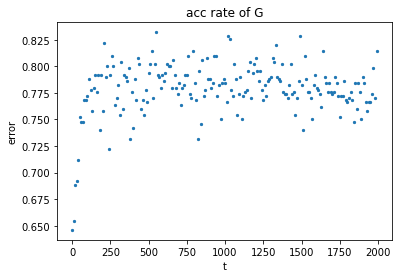

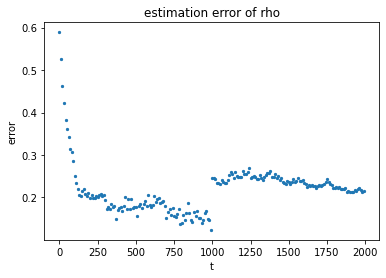

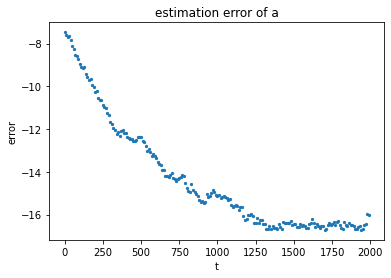

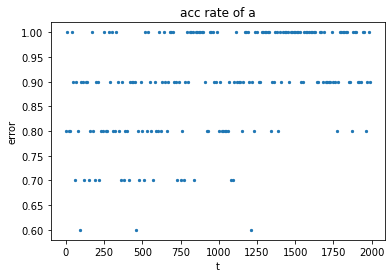

----------------------------------------------------------------------------------------------------
rho_1, rho_2, a_1, a_2 = mle, mean, mle, mle	
accept rate of a, G for the last iteration: 0.78
ave error G: 0.43803321860754607
error rho: 0.14853239226904957
error a: -16.266382875666594


P(difference<0.5)= 0.76
P(difference<0.4)= 0.5
P(difference<0.3)= 0.22
P(difference<0.2)= 0.0
P(difference<0.1)= 0.0


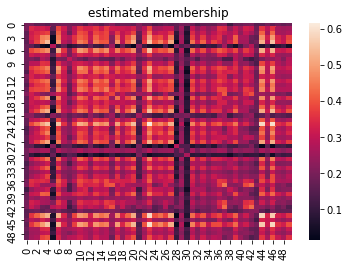

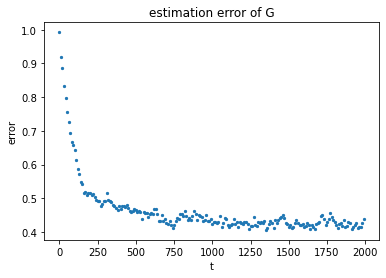

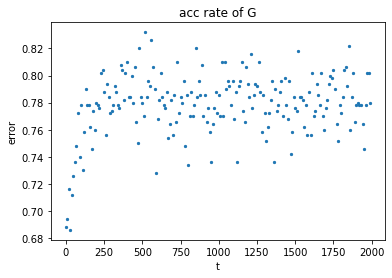

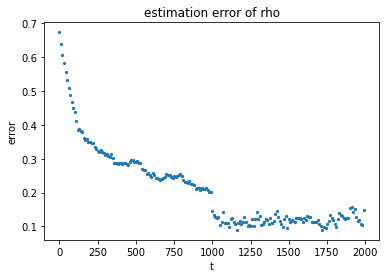

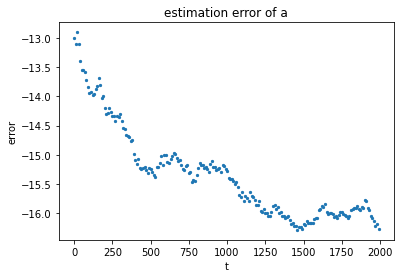

----------------------------------------------------------------------------------------------------
rho_1, rho_2, a_1, a_2 = mle, mean, mle, sampling	
accept rate of a, G for the last iteration: 0.768
ave error G: 0.40633626648308835
error rho: 0.20353209378650522
error a: -13.579946190320562


P(difference<0.5)= 0.72
P(difference<0.4)= 0.48
P(difference<0.3)= 0.24
P(difference<0.2)= 0.06
P(difference<0.1)= 0.0


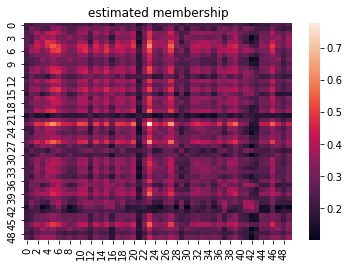

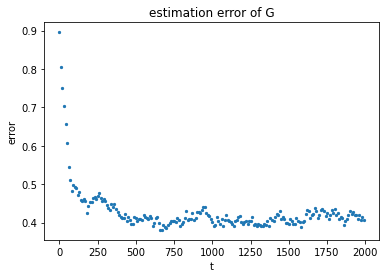

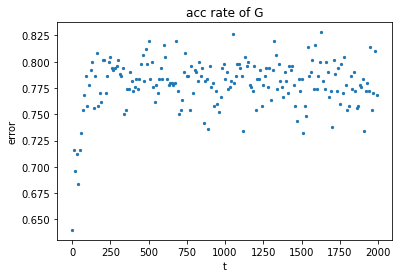

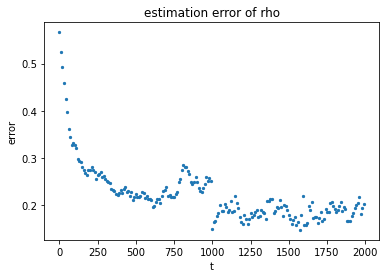

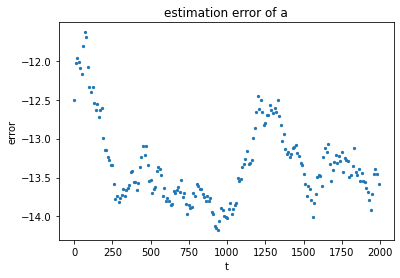

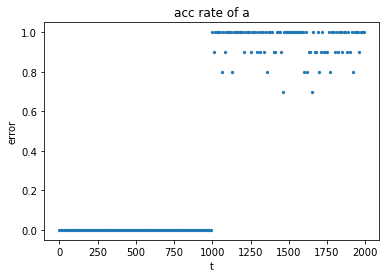

----------------------------------------------------------------------------------------------------
rho_1, rho_2, a_1, a_2 = mle, mean, sampling, mle	
accept rate of a, G for the last iteration: 0.76
ave error G: 0.41109581626637903
error rho: 0.11079445602867936
error a: -16.15584598307054


P(difference<0.5)= 0.74
P(difference<0.4)= 0.54
P(difference<0.3)= 0.24
P(difference<0.2)= 0.08
P(difference<0.1)= 0.0


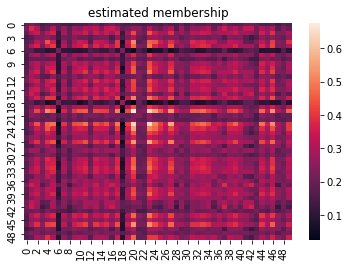

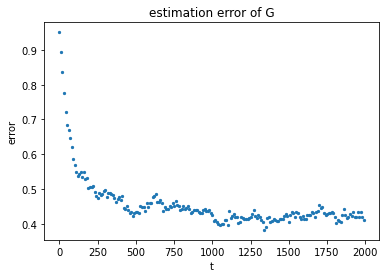

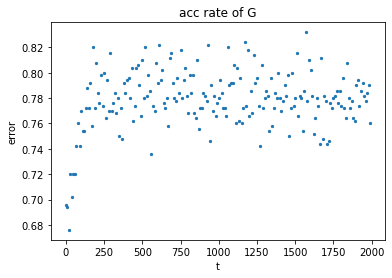

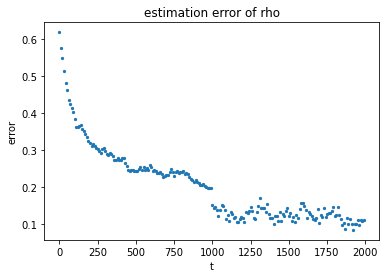

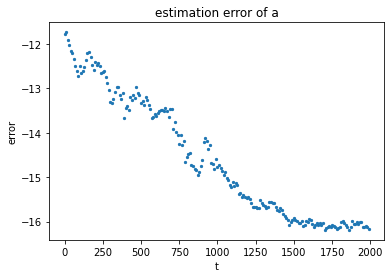

----------------------------------------------------------------------------------------------------
rho_1, rho_2, a_1, a_2 = mle, mean, sampling, sampling	
accept rate of a, G for the last iteration: 0.7979999999999999
ave error G: 0.3829880832523227
error rho: 0.15267972100036775
error a: -14.019986006964587


P(difference<0.5)= 0.78
P(difference<0.4)= 0.5
P(difference<0.3)= 0.34
P(difference<0.2)= 0.08
P(difference<0.1)= 0.0


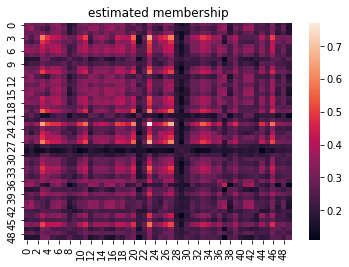

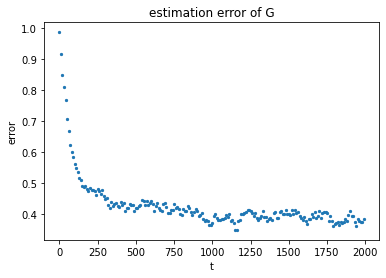

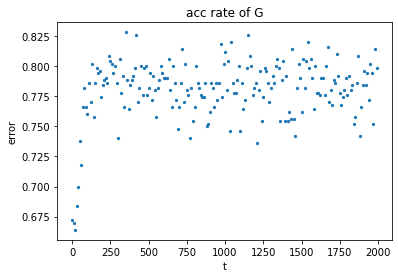

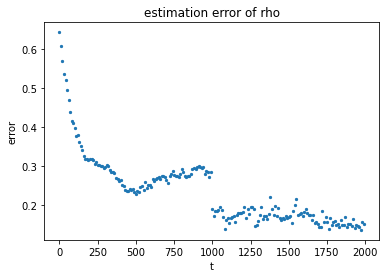

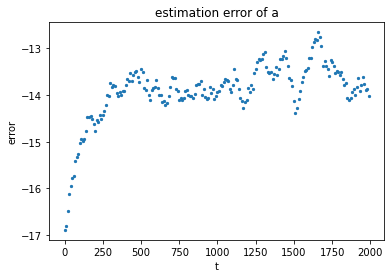

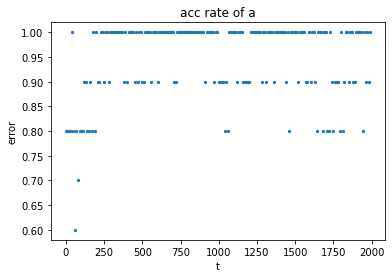

----------------------------------------------------------------------------------------------------
rho_1, rho_2, a_1, a_2 = mle, mle, mle, mle	
accept rate of a, G for the last iteration: 0.804
ave error G: 0.4062154667088123
error rho: 0.26167106350232716
error a: -14.12464878162117


P(difference<0.5)= 0.74
P(difference<0.4)= 0.58
P(difference<0.3)= 0.26
P(difference<0.2)= 0.08
P(difference<0.1)= 0.0


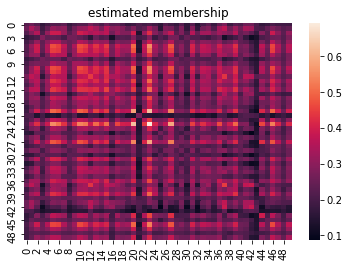

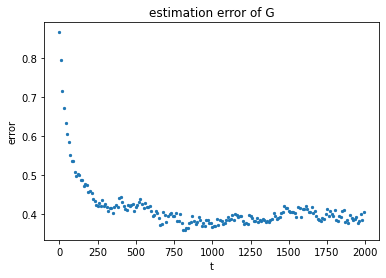

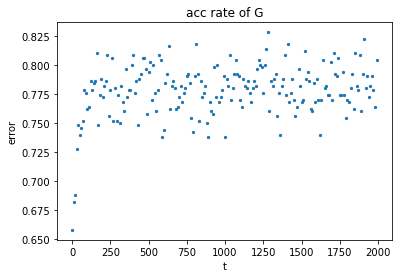

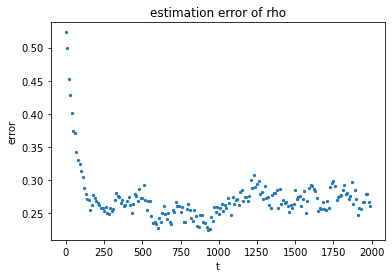

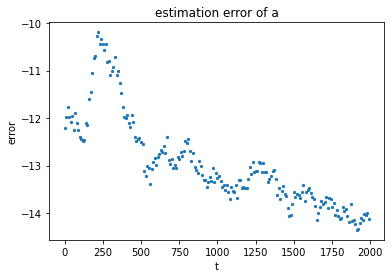

----------------------------------------------------------------------------------------------------
rho_1, rho_2, a_1, a_2 = mle, mle, mle, sampling	
accept rate of a, G for the last iteration: 0.764
ave error G: 0.40528304683311317
error rho: 0.21719722375180084
error a: -14.91824338471513


P(difference<0.5)= 0.78
P(difference<0.4)= 0.52
P(difference<0.3)= 0.26
P(difference<0.2)= 0.08
P(difference<0.1)= 0.0


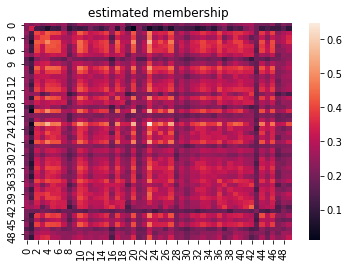

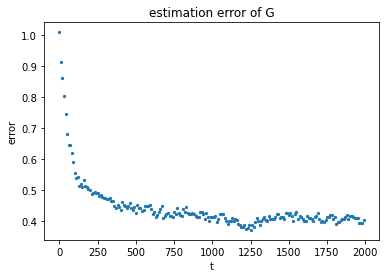

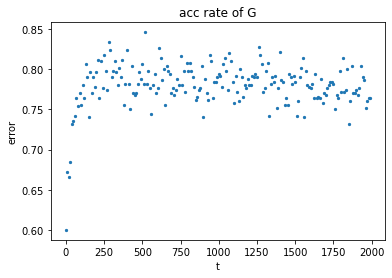

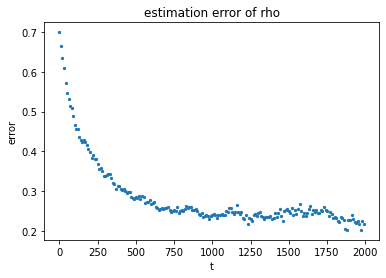

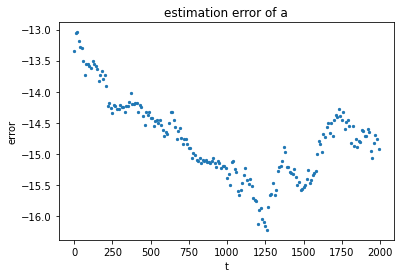

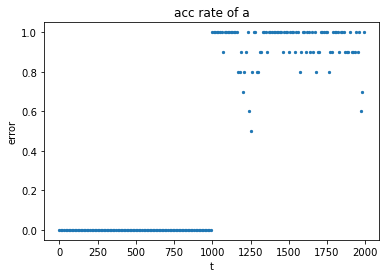

----------------------------------------------------------------------------------------------------
rho_1, rho_2, a_1, a_2 = mle, mle, sampling, mle	
accept rate of a, G for the last iteration: 0.774
ave error G: 0.45336292312692783
error rho: 0.30039555483934
error a: -15.522228307530309


P(difference<0.5)= 0.68
P(difference<0.4)= 0.46
P(difference<0.3)= 0.26
P(difference<0.2)= 0.04
P(difference<0.1)= 0.0


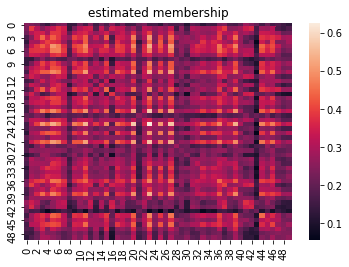

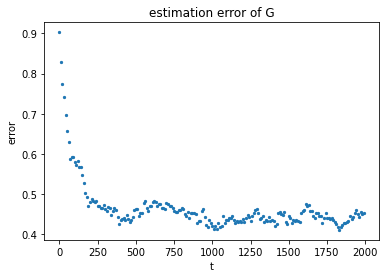

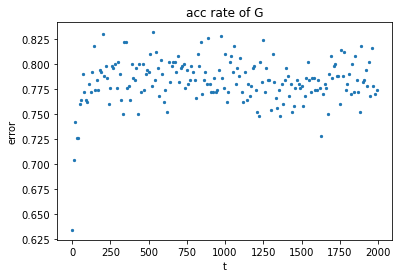

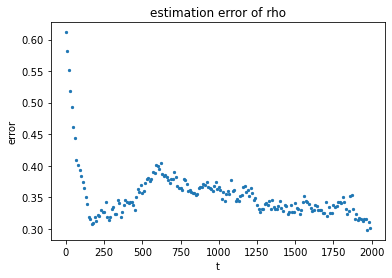

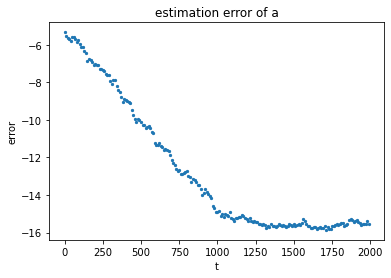

----------------------------------------------------------------------------------------------------
rho_1, rho_2, a_1, a_2 = mle, mle, sampling, sampling	
accept rate of a, G for the last iteration: 0.7959999999999999
ave error G: 0.39747216991299367
error rho: 0.16860437384561414
error a: -9.110782350334988


P(difference<0.5)= 0.78
P(difference<0.4)= 0.58
P(difference<0.3)= 0.28
P(difference<0.2)= 0.06
P(difference<0.1)= 0.0


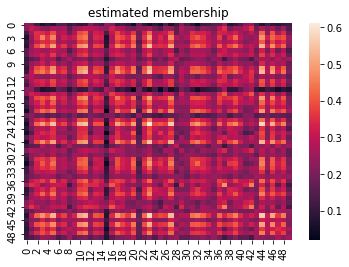

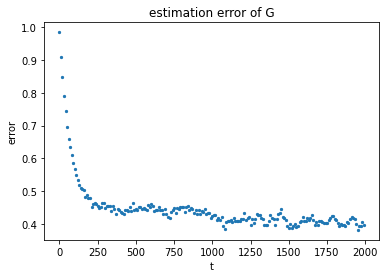

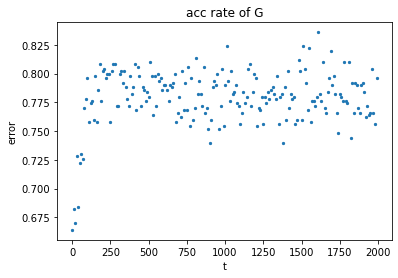

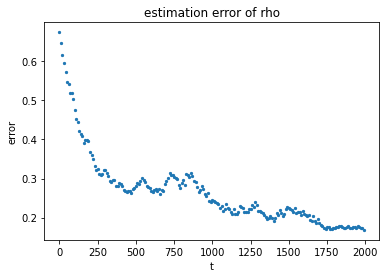

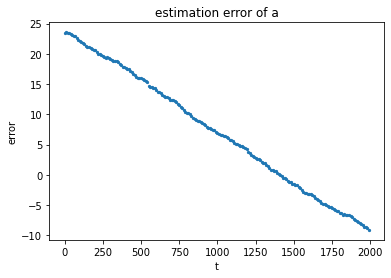

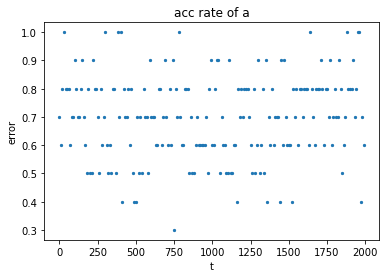

In [8]:
res = []
for i1 in ["mean", "mle"]:
    for i2 in ["mean", "mle"]:
        for j1 in ["mle", 'sampling']:
            for j2 in ["mle", 'sampling']:
                print("\033[31m%s\033[0m"%("-"*100))
                print("\033[37;41mrho_1, rho_2, a_1, a_2 = %s, %s, %s, %s\t\033[0m"%(i1,i2,j1,j2))
                res.append(tuningp(sigmaa=0.05, sigmarho=0.1, sigmag=0.01, nconverge=1000, nskip=10, nsave=100,a=a,rho_1=i1,rho_2=i2,a_1=j1, a_2=j2))

In [9]:
print(a)
print(rho)

20.204406609354525
[4.04778552e-01 1.34047266e-01 5.24520167e-02 2.05896942e-01
 1.44293998e-01 5.84814091e-02 4.98172120e-05]


In [11]:
np.save("./data5/rho.npy", rho)

In [12]:
np.save("./data5/X.npy", X)
np.save("./data5/Y.npy", Y)
np.save("./data5/G.npy", G)
np.save("./data5/mu.npy", mu)
np.save("./data5/s_inv.npy", s_inv)

In [153]:
# np.load("./data1/X.npy")c

In [13]:
# save estimate of a
tema = []
for i in range(16):
    tema.append(res[i][0])
tema = np.array(tema)
# tema[i] is the estimate of a in experiment i
np.save("./data5/estimate_of_a.npy", tema)

In [14]:
temg = []
for i in range(16):
    temg.append(res[i][1])
temg = np.array(temg)
# print(temg.shape)
np.save("./data5/estimate_of_G.npy", temg)
# print(temg[0][0][0][0])
# print(np.load("./data1/estimate_of_G.npy")[0][0][0][0])

In [15]:
temrho = []
for i in range(16):
    temrho.append(res[i][2])
temrho = np.array(temrho)
# print(temrho.shape)
np.save("./data5/estimate_of_rho.npy", temrho)
# print(temrho[0][0][0])
# print(np.load("./data1/estimate_of_rho.npy")[0][0][0])

In [ ]:
# res[i]: res of experiment i
# res[i][j=0,...5] asave, Gs, rhos, ara, arG, arrho
# res[i][j][0,...,500]

In [32]:
# Check whether we can increase infinity
temn = 1000
infi = 10**(-3)
pY = [0]*temn+[1]*temn
u1 = [0]*11
u2 = [infi]*11
for i in range(11):
    print(i)
    u1 = [0]*11
    u2 = [infi]*11
    u1[i]=1
    sx1, mux1 = para_x(u1, s2, tao)
#     X1 = np.random.multivariate_normal(mux, sx,temn)
    u2[i]=1-10*infi
    sx2, mux2 = para_x(u2, s2, tao)
    print(abs(mux1-mux2).sum())
    print(abs(sx1-sx2).sum())
#     X2 = np.random.multivariate_normal(mux, sx,temn)
#     pX = np.array(list(X1)+list(X2))
#     fig_pure_type = plt.figure()
#     ax = Axes3D(fig_pure_type)
#     ax.scatter(pX[:, 0], pX[:, 1], pX[:, 2], c = pY)
#     plt.show()

0
1.7670240653835327
4.8339129237982705
1
3.1315636356069136
4.928004346102144
2
2.7285174473399136
4.6504269027165686
3
2.2788998285022726
3.6199452593828796
4
1.7327495694921293
6.555383395515866
5
5.420329735300938
8.176272738075884
6
1.5252765813715135
4.734359753312548
7
2.0915695902051166
6.863229978638341
8
2.3087042378987874
7.956578028727521
9
2.554604268653506
5.429662735274681
10
2.4322654465533495
7.961888101186953


In [35]:
# we have 11 topics
temn = 1000
infi = 10**(-5)
pY = [0]*temn+[1]*temn
u1 = [0]*11
u2 = [infi]*11
for i in range(11):
    print(i)
    u1 = [0]*11
    u2 = [infi]*11
    u1[i]=1
    sx1, mux1 = para_x(u1, s2, tao)
#     X1 = np.random.multivariate_normal(mux, sx,temn)
    u2[i]=1-10*infi
    sx2, mux2 = para_x(u2, s2, tao)
    print(abs(mux1-mux2).sum())
    print(abs(sx1-sx2).sum())
#     X2 = np.random.multivariate_normal(mux, sx,temn)
#     pX = np.array(list(X1)+list(X2))
#     fig_pure_type = plt.figure()
#     ax = Axes3D(fig_pure_type)
#     ax.scatter(pX[:, 0], pX[:, 1], pX[:, 2], c = pY)
#     plt.show()

0
0.018053691697823115
0.04978223666892259
1
0.03219744920054057
0.050818964278114304
2
0.027903190795634858
0.04777514896057484
3
0.023169139283524876
0.037056688627146395
4
0.017762119997888293
0.06788246053820282
5
0.05683262302872888
0.08556108597026726
6
0.01553123715798832
0.04890090915813738
7
0.02130424918048046
0.07125312198093171
8
0.023797234117525656
0.08299847404702737
9
0.026260932604639797
0.05600473927770821
10
0.025140681616006272
0.08260503843197246
